### Importing Important Library

In [1]:
from pip._internal import main
main(["install","nltk"])


0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame
import re
from random import shuffle
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

%matplotlib inline

Using TensorFlow backend.


### Importing Dataset

In [77]:
train_csv = pd.read_csv('data/Train.csv')
test_csv = pd.read_csv('data/Test.csv')

### Having a look at Dataset

In [78]:
train_csv.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description,Product_Category
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376


In [79]:
test_csv.head()

,Inv_Id,Vendor_Code,GL_Code,Inv_Amt,Item_Description
0,15003,VENDOR-2513,GL-6050310,56.13,Travel and Entertainment Miscellaneous Company...
1,15008,VENDOR-1044,GL-6101400,96.56,Final Site Clean Up Store Construction Advance...
2,15013,VENDOR-1254,GL-6101400,55.93,Arabian American Development Co Final Site Cle...
3,15019,VENDOR-1331,GL-2182000,32.62,Corporate Services Contingent Labor/Temp Labor...
4,15020,VENDOR-2513,GL-6050310,25.81,Fortune National Corp Miscellaneous Company Ca...


In [80]:
train_csv.describe()

,Inv_Id,Inv_Amt
count,5566.000000,5566.000000
mean,19010.787100,49.980151
std,2306.607485,28.903030
min,15001.000000,0.010000
25%,17006.250000,24.957500
50%,19017.500000,49.645000
75%,20994.750000,75.170000
max,23012.000000,99.990000


In [81]:
print(train_csv.info())
print(test_csv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 6 columns):
Inv_Id              5566 non-null int64
Vendor_Code         5566 non-null object
GL_Code             5566 non-null object
Inv_Amt             5566 non-null float64
Item_Description    5566 non-null object
Product_Category    5566 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 261.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446 entries, 0 to 2445
Data columns (total 5 columns):
Inv_Id              2446 non-null int64
Vendor_Code         2446 non-null object
GL_Code             2446 non-null object
Inv_Amt             2446 non-null float64
Item_Description    2446 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 95.6+ KB
None


## Understanding Data
description with same motive come under same category for example

We can see that all rent and Lease product come under class Id 1274

*  Base Rent May2016 Store Management Compuserve Corp Real Estate Lease/Rent | class id is 1274.
*  Store Management Lease/Rent Advance Ross Corp Real Estate Base Rent 2011-Sep  | class id is 1274.
*  Real Estate Lease/Rent Base Rent Bancwest Corp/Hi 2011-May  Store Management | class id is 1274.


## Def all the function.

In [82]:
def adding_word_to_vocab(csv,col,vocabulary = set(),max_ = 28):
    ## ADDING WORD TO VOCAB FROM DATASET AND FINDING MAXIMUM LENGHT OF A SENTENCE.
    descrip = []
    for index in range(csv.shape[0]):
        descrip.append(csv.iloc[index,col].lower())
        word_token = word_tokenize(csv.iloc[index,col].lower())
        vocabulary |= set(word_token)
    return descrip,vocabulary,max_


def indexing_words(vocabulary, vocab_to_idx =  {}, idx_to_vocab = {}):
    ### WORDS TO INDEX
    ### INDEX TO WORDS
    ### EXAMPLE
    ### WORDS TO INDEX = {'IS' : 4,'THE': 6}
    ### INDEX TO WORDS = {4: 'IS', 6 : 'THE'}
    for i in range(1,len(vocabulary)+1):
        vocab_to_idx[list(vocabulary)[i-1]] = i
        idx_to_vocab[i] = list(vocabulary)[i-1]
    
    return idx_to_vocab, vocab_to_idx

def changing_description(descrip,vocab_to_idx,csv,max_):
    _id = np.zeros((csv.shape[0],max_))
    for i in range(len(descrip)):
        for j,u in zip(word_tokenize(descrip[i]),range(len(word_tokenize(descrip[i])))):
            _id[i,u] = vocab_to_idx[j]
    return _id

In [83]:
def Item_desc_preprocessing(train_csv,test_csv,col):
    
    '''
    BUILDING VOCABULARY 
    INDEXING EVERY WORD IN VOCABULARY (assigning every a word a number)
    CHANGING ITEM_DESCRIPTON OF TRAINING DATA AND TEST DATA INTO NUMBER BY INDEXING
    '''

    
    ## ADDING WORD TO VOCAB FROM TRAIN DATASET.
    train_descrip, vocabulary,max_ = adding_word_to_vocab(train_csv,col)
    
    ## ADDING WORD TO VOCAB FROM TEST DATASET.
    test_descrip,vocabulary, max_ = adding_word_to_vocab(test_csv, col ,vocabulary,max_)
    
    ### CHANGING WORD TO NUMERIC AND NUMRIC TO WORD
    idx_to_vocab, vocab_to_idx = indexing_words(vocabulary)
    
    ### CHANGING TRAIN DESCRIPTION TO NUMERIC
    train_id = changing_description(train_descrip,vocab_to_idx,train_csv,max_)
    
    ### CHANGING TEST DESCRIPTION TO NUMERIC
    test_id = changing_description(test_descrip,vocab_to_idx,test_csv,max_)
    
    return list(vocabulary), max_,[train_descrip,test_descrip], [vocab_to_idx, idx_to_vocab], [train_id,test_id]

In [84]:
def get_label(train_csv, one_hot = True):
    '''
    CHANGING LABEL FROM CLASS-XXXX TO A NUMBER
    OHE HOT ENCODING OF DATA
    '''
   
    no_of_label = np.unique(np.array([ train_csv.iloc[i,-1] for i in range(train_csv.shape[0])]))
    label = np.zeros((train_csv.shape[0]))

    OHE_label = np.zeros((train_csv.shape[0],no_of_label.shape[0]))
    labels = {}
    
    for i in range(no_of_label.shape[0]):
        labels[no_of_label[i]] = i
   
    for index in range(train_csv.shape[0]):
        
        label[index] = labels[train_csv.iloc[index,-1]]
        
        OHE_of_label = np.zeros((no_of_label.shape[0]))
        OHE_of_label[int(label[index])] = 1
        OHE_label[index] = OHE_of_label
    
    if one_hot == True:
        return label ,OHE_label,labels
    if one_hot == False:
        return label,labels 

In [85]:
def acc(y_test,prediction):


    cm = confusion_matrix(y_test, prediction)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    
    #print ('Recall:', recall)
    #print ('Precision:', precision)
    print ('\n clasification report:\n', classification_report(y_test,prediction))
    #print ('\n confussion matrix:\n',confusion_matrix(y_test, prediction))]
    ax = sns.heatmap(confusion_matrix(y_test, prediction),linewidths= 0.5,cmap="YlGnBu")

In [86]:
def plot_distribution(label,l,in_numeric = 0,get_plot = True,get_return = False):
    no_of_class = 36
    label = np.array(label)
    print(label.shape)
    classes = {}
    if get_plot == True:
        sns.set(color_codes=True)
        sns.distplot(l,label = 'LABELS',kde=False
                     ,color='red',norm_hist=False,rug=False);
    
    if in_numeric > 0:
        uni, count = np.unique(label,return_counts= True)
        print("max is:",max(count)," min is: ",min(count))
        for clas in range(count.shape[0]):
            classes[str(uni[clas])] = count[clas]
    if get_return == True:
        return classes

In [112]:
def getting_submission_file(file_name,y):   
    ### CONVERTING BACK TO CLASS- XXXX
    Inv_ID = np.arange(1,y.shape[1]+1, dtype = 'int64').reshape(y.shape)
    con = np.concatenate((Inv_ID,y))
    pd.DataFrame(con).to_csv(file_name)

In [88]:
def conv_label(label_conv):
    key = list(label_conv.keys())
    value = list(label_conv.values())
    label_conversion = {}
    for i in range(len(key)):
        label_conversion[value[i]] = key[i]
    return label_conversion  

## Processing Data

In [146]:
vocabulary, maxi_desc , descriptions, word_change , desc_idx = Item_desc_preprocessing(train_csv,test_csv,4)
len(vocabulary), maxi_desc, len(descriptions),len(word_change),desc_idx[0].shape, desc_idx[1].shape

(2916, 28, 2, 2, (5566, 28), (2446, 28))

In [147]:
label , OHE, label_conv= get_label(train_csv)

distribution of overall dataset:
(5566,)
max is: 1498  min is:  1


{'CLASS-1248': 5,
 'CLASS-1249': 176,
 'CLASS-1250': 451,
 'CLASS-1274': 986,
 'CLASS-1294': 25,
 'CLASS-1309': 32,
 'CLASS-1322': 28,
 'CLASS-1376': 365,
 'CLASS-1429': 32,
 'CLASS-1477': 50,
 'CLASS-1522': 851,
 'CLASS-1567': 84,
 'CLASS-1652': 15,
 'CLASS-1688': 4,
 'CLASS-1721': 107,
 'CLASS-1758': 1498,
 'CLASS-1770': 19,
 'CLASS-1805': 12,
 'CLASS-1828': 113,
 'CLASS-1838': 1,
 'CLASS-1850': 60,
 'CLASS-1867': 15,
 'CLASS-1870': 36,
 'CLASS-1919': 70,
 'CLASS-1957': 1,
 'CLASS-1963': 230,
 'CLASS-1964': 28,
 'CLASS-1983': 17,
 'CLASS-2003': 32,
 'CLASS-2015': 2,
 'CLASS-2038': 13,
 'CLASS-2112': 53,
 'CLASS-2141': 108,
 'CLASS-2146': 2,
 'CLASS-2152': 9,
 'CLASS-2241': 36}

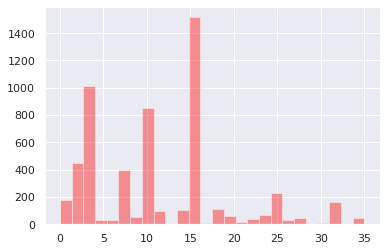

In [148]:
print("distribution of overall dataset:")
plot_distribution(train_csv.iloc[:,-1],label,in_numeric=2,get_return = True)

In [149]:
label,OHE

(array([25.,  2.,  3., ..., 14., 12., 15.]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [150]:
label_conversion = conv_label(label_conv)
label_conversion

{0: 'CLASS-1248',
 1: 'CLASS-1249',
 2: 'CLASS-1250',
 3: 'CLASS-1274',
 4: 'CLASS-1294',
 5: 'CLASS-1309',
 6: 'CLASS-1322',
 7: 'CLASS-1376',
 8: 'CLASS-1429',
 9: 'CLASS-1477',
 10: 'CLASS-1522',
 11: 'CLASS-1567',
 12: 'CLASS-1652',
 13: 'CLASS-1688',
 14: 'CLASS-1721',
 15: 'CLASS-1758',
 16: 'CLASS-1770',
 17: 'CLASS-1805',
 18: 'CLASS-1828',
 19: 'CLASS-1838',
 20: 'CLASS-1850',
 21: 'CLASS-1867',
 22: 'CLASS-1870',
 23: 'CLASS-1919',
 24: 'CLASS-1957',
 25: 'CLASS-1963',
 26: 'CLASS-1964',
 27: 'CLASS-1983',
 28: 'CLASS-2003',
 29: 'CLASS-2015',
 30: 'CLASS-2038',
 31: 'CLASS-2112',
 32: 'CLASS-2141',
 33: 'CLASS-2146',
 34: 'CLASS-2152',
 35: 'CLASS-2241'}

In [151]:
### TRAINGING AND TESTING DATA
train_desc = X = desc_idx[0]
test_desc = desc_idx[1]
Y = label

distribution of test:
(5566,)
max is: 1498  min is:  1


{'0.0': 5,
 '1.0': 176,
 '2.0': 451,
 '3.0': 986,
 '4.0': 25,
 '5.0': 32,
 '6.0': 28,
 '7.0': 365,
 '8.0': 32,
 '9.0': 50,
 '10.0': 851,
 '11.0': 84,
 '12.0': 15,
 '13.0': 4,
 '14.0': 107,
 '15.0': 1498,
 '16.0': 19,
 '17.0': 12,
 '18.0': 113,
 '19.0': 1,
 '20.0': 60,
 '21.0': 15,
 '22.0': 36,
 '23.0': 70,
 '24.0': 1,
 '25.0': 230,
 '26.0': 28,
 '27.0': 17,
 '28.0': 32,
 '29.0': 2,
 '30.0': 13,
 '31.0': 53,
 '32.0': 108,
 '33.0': 2,
 '34.0': 9,
 '35.0': 36}

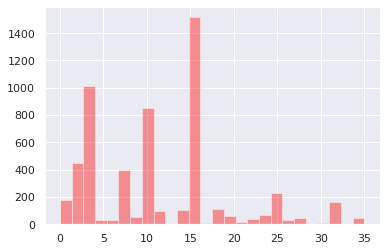

In [152]:
print("distribution of test:")
plot_distribution(Y,Y,in_numeric=1,get_return=True)

In [ ]:
type(x_train),type(y_train)
np.save('x_train.npy',x_train)
np.save('x_test.npy',x_test)
np.save('y_test.npy',y_test)
np.save('y_train.npy',y_train)

# MODEL

In [177]:
## USING XGBOOST TO CLASSIFY
def classifier_xgb( x_train,y_train,x_test,y_test,objective = 'multi:softmax',eta = 0.2,base_score= 0.8,booster='gbtree',n_estimators = 900,max_depth = 70,
                    silent = 0,num_class = 36,nrounds  = 1100 ,gamma =  0.01,verbose=1 ,acc = False):

    classifier = XGBClassifier(objective = objective ,eta = eta,base_score= base_score,booster= booster,
    n_estimators = n_estimators,n_jobs= 4,max_depth = max_depth,num_class = num_class,nrounds  = nrounds ,gamma =  gamma,verbose=verbose )
    classifier.fit(x_train,y_train)
    if acc == True:
        print("classifier.score: ",classifier.score(x_test,y_test))
        acc(y_test,classifier.predict(x_test))
    return classifier, classifier.predict_proba(x_test)

In [178]:
def classifier_rangfors(x_train,y_train,x_test,y_test, n_estimators = 900,depth= 50, acc = False):
        classifier = RandomForestClassifier(n_jobs= 4,n_estimators= n_estimators,max_depth= depth)
        classifier.fit(x_train,y_train)
        if acc == True:
            print("classifier.score: ",classifier.score(x_test,y_test))
            acc(y_test,classifier.predict(x_test))
        return classifier, classifier.predict_proba(x_test)

In [140]:
def predict(x_train,y_train,test_desc,y_TEST):
    classifier_xg,proba_xgb = classifier_xgb( x_train,y_train,test_desc,y_test)
    classifier_rf,proba_rf = classifier_rangfors( x_train,y_train,test_desc,y_test)
    y_pred =[]
    for i in range(test_desc.shape[0]):   
        y_pred.append(np.argmax(proba_rf[i] + proba_xgb[i]))
    y_pred = np.array(y_pred)
    return y_pred

In [153]:
y_pred = predict(X,Y,test_desc,None)

/home/ravisingh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/ravisingh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.95      0.95      0.95        78
           2       0.99      0.99      0.99       201
           3       0.98      0.99      0.98       457
           4       1.00      0.90      0.95        10
           5       0.87      1.00      0.93        13
           6       0.87      1.00      0.93        13
           7       0.96      1.00      0.98       150
           8       0.94      0.80      0.86        20
           9       0.93      0.90      0.91        29
          10       0.99      0.99      0.99       402
          11       0.97      0.94      0.95        31
          12       1.00      1.00      1.00         3
          14       0.98      0.98      0.98        55
          15       0.99      1.00      0.99       651
          16       1.00      1.00      1.00         7
          17       0.00      0.00      0.00         1
  

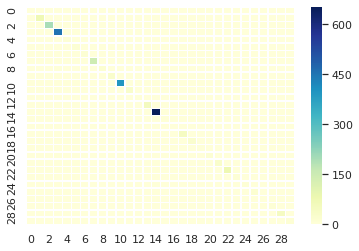

In [154]:
acc(y_TEST,y_pred)

In [155]:
getting_submission_file("submission/no_sampling_file_sub.csv",y_pred.reshape(1,y_pred.shape[0]))

## UNDERSAMPLING

In [156]:
base_line = 80

In [157]:
def under_sampling(base_line,label_conversion,train_csv):  
    undsam = []
    scor = {}
    for i in label_conversion.values():
        scor[i]= 0
    for i in range(train_csv.shape[0]):
        if scor[str(train_csv.iloc[i,-1])]<base_line:
            scor[str(train_csv.iloc[i,-1])] +=1
            undsam.append(np.array(train_csv.iloc[i,:]))
    undsam_ = pd.DataFrame(undsam)
    return undsam_

In [158]:
undsam_ = under_sampling(base_line,label_conversion,train_csv)
under_sampling(base_line,label_conversion,train_csv).head()

,0,1,2,3,4,5
0,15001,VENDOR-1676,GL-6100410,83.24,Artworking/Typesetting Production Jun 2009 Cha...,CLASS-1963
1,15002,VENDOR-1883,GL-2182000,51.18,Auto Leasing Corporate Services Corning Inc /N...,CLASS-1250
2,15004,VENDOR-1999,GL-6050100,79.02,Store Management Lease/Rent Deltona Corp Real ...,CLASS-1274
3,15005,VENDOR-1771,GL-6101400,48.50,Store Construction General Requirements Coloni...,CLASS-1522
4,15006,VENDOR-1331,GL-2182000,63.35,Jul 2015 Aydin Corp Contingent Labor/Temp Labo...,CLASS-1376


In [159]:
vocabulary, maxi_desc , descriptions, word_change , desc_idx = Item_desc_preprocessing(undsam_,test_csv,4)
len(vocabulary), maxi_desc, len(descriptions),len(word_change),desc_idx[0].shape, desc_idx[1].shape

(2916, 28, 2, 2, (1477, 28), (2446, 28))

In [160]:
label , OHE, label_conv= get_label(undsam_)

In [162]:
### TRAINGING AND TESTING DATA
train_desc = X = desc_idx[0]
test_desc = desc_idx[1]
Y = label

distribution of train:
(1477,)
max is: 80  min is:  1


{'0.0': 5,
 '1.0': 80,
 '2.0': 80,
 '3.0': 80,
 '4.0': 25,
 '5.0': 32,
 '6.0': 28,
 '7.0': 80,
 '8.0': 32,
 '9.0': 50,
 '10.0': 80,
 '11.0': 80,
 '12.0': 15,
 '13.0': 4,
 '14.0': 80,
 '15.0': 80,
 '16.0': 19,
 '17.0': 12,
 '18.0': 80,
 '19.0': 1,
 '20.0': 60,
 '21.0': 15,
 '22.0': 36,
 '23.0': 70,
 '24.0': 1,
 '25.0': 80,
 '26.0': 28,
 '27.0': 17,
 '28.0': 32,
 '29.0': 2,
 '30.0': 13,
 '31.0': 53,
 '32.0': 80,
 '33.0': 2,
 '34.0': 9,
 '35.0': 36}

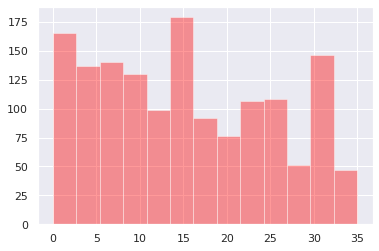

In [163]:
print("distribution of train:")
plot_distribution(label,label,in_numeric=1,get_return=True)

In [164]:
y_pred = predict(X,Y,test_desc,None)


 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.95      0.95      0.95        78
           2       0.95      0.99      0.97       201
           3       0.99      0.94      0.96       457
           4       0.80      0.80      0.80        10
           5       0.60      0.92      0.73        13
           6       0.81      1.00      0.90        13
           7       0.97      0.96      0.97       150
           8       0.94      0.75      0.83        20
           9       0.87      0.90      0.88        29
          10       1.00      0.91      0.95       402
          11       0.91      0.97      0.94        31
          12       1.00      1.00      1.00         3
          14       0.88      0.84      0.86        55
          15       1.00      1.00      1.00       651
          16       0.86      0.86      0.86         7
          17       0.00      0.00      0.00         1
  

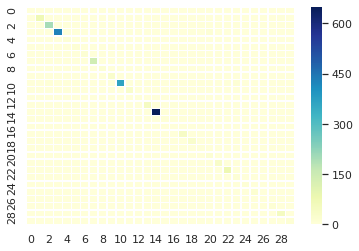

In [165]:
acc(y_TEST,y_pred)

In [167]:
getting_submission_file("submission/under_sampling.csv",y_pred.reshape(1,y_pred.shape[0]))

## OVERSAMPLING

In [168]:
base_line = 500

In [169]:
def over_sampling(base_line,label_conversion,train_csv):  
    ovrsamp = []
    scor = {}
    for i in label_conversion.values():
        scor[i]= 0
    for i in range(train_csv.shape[0]):
        if scor[str(train_csv.iloc[i,-1])] < base_line + 250:
            scor[str(train_csv.iloc[i,-1])] +=1
            ovrsamp.append(np.array(train_csv.iloc[i,:]))
    ovrsamp_ = pd.DataFrame(ovrsamp)
    return ovrsamp_

In [170]:
train_csv1 = over_sampling(base_line,label_conversion,train_csv)
uni,  count = np.unique(np.array(over_sampling(base_line,label_conversion,train_csv).iloc[:,-1]),return_counts = True)
uni, count,train_csv1.shape

(array(['CLASS-1248', 'CLASS-1249', 'CLASS-1250', 'CLASS-1274',
        'CLASS-1294', 'CLASS-1309', 'CLASS-1322', 'CLASS-1376',
        'CLASS-1429', 'CLASS-1477', 'CLASS-1522', 'CLASS-1567',
        'CLASS-1652', 'CLASS-1688', 'CLASS-1721', 'CLASS-1758',
        'CLASS-1770', 'CLASS-1805', 'CLASS-1828', 'CLASS-1838',
        'CLASS-1850', 'CLASS-1867', 'CLASS-1870', 'CLASS-1919',
        'CLASS-1957', 'CLASS-1963', 'CLASS-1964', 'CLASS-1983',
        'CLASS-2003', 'CLASS-2015', 'CLASS-2038', 'CLASS-2112',
        'CLASS-2141', 'CLASS-2146', 'CLASS-2152', 'CLASS-2241'],
       dtype=object),
 array([  5, 176, 451, 750,  25,  32,  28, 365,  32,  50, 750,  84,  15,
          4, 107, 750,  19,  12, 113,   1,  60,  15,  36,  70,   1, 230,
         28,  17,  32,   2,  13,  53, 108,   2,   9,  36]),
 (4481, 6))

In [171]:
def duplicating_categories(uni, count,csv,base_line,label_conversion):
    array_dataset = np.array(over_sampling(base_line,label_conversion,csv))
    lif = list()
    print(array_dataset.shape)
    for categ in range(uni.shape[0]):
        if count[categ] <  base_line:
            times_addition= base_line // count[categ] 
            add_data = np.array(csv[csv.iloc[:,-1] == uni[categ]])
            for x in range(times_addition):
                array_dataset = np.concatenate((array_dataset,add_data))
    return array_dataset

In [172]:
train_data_oversam = duplicating_categories(uni, count,train_csv,base_line,label_conversion)
train_data_oversam.shape

(4481, 6)


(20074, 6)

In [173]:
vocabulary, maxi_desc , descriptions, word_change , desc_idx = Item_desc_preprocessing(pd.DataFrame(train_data_oversam),test_csv,4)
len(vocabulary), maxi_desc, len(descriptions),len(word_change),desc_idx[0].shape, desc_idx[1].shape

(2916, 28, 2, 2, (20074, 28), (2446, 28))

In [174]:
label , OHE, label_conv= get_label(pd.DataFrame(train_data_oversam))

In [180]:
### TRAINGING AND TESTING DATA
train_desc = X = desc_idx[0]
test_desc = desc_idx[1]
Y = label

distribution of train:
(16059,)
max is: 729  min is:  389


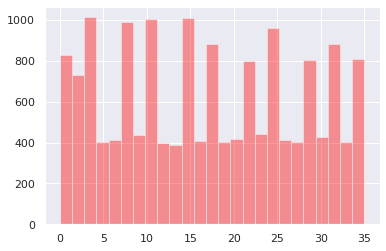

In [70]:
print("distribution of train:")
plot_distribution(y_train,y_train,in_numeric=2)

In [181]:
y_pred = predict(X,Y,test_desc,None)

/home/ravisingh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/ravisingh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



 clasification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.99      0.96      0.97        78
           2       0.99      1.00      0.99       201
           3       0.99      0.99      0.99       457
           4       1.00      0.90      0.95        10
           5       0.80      0.92      0.86        13
           6       0.93      1.00      0.96        13
           7       1.00      0.99      1.00       150
           8       1.00      0.95      0.97        20
           9       0.93      0.97      0.95        29
          10       1.00      1.00      1.00       402
          11       0.94      0.94      0.94        31
          12       1.00      1.00      1.00         3
          14       0.98      0.98      0.98        55
          15       1.00      1.00      1.00       651
          16       1.00      1.00      1.00         7
          17       0.00      0.00      0.00         1
  

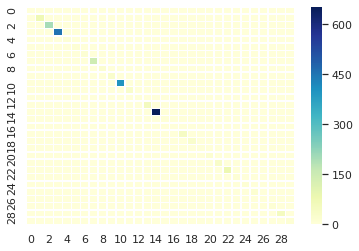

In [182]:
acc(y_TEST,y_pred)

In [183]:
getting_submission_file("submission/over_sampling.csv",y_pred.reshape(1,y_pred.shape[0]))